In [ ]:
!pip install -e ..

## Data Loading

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

from instaffo_matching.data.loader import load_data, get_matching_dataframes
from instaffo_matching.data.preprocessor import standardize_data
from instaffo_matching.features.engineer import FeatureEngineer

# Load data
data = load_data("../data/data.json")
talent_df, job_df, labels_df = get_matching_dataframes(data=data)

In [3]:
# Encodes categorical variables (degree, seniority, languages) into numerical values.
# This will be akin to ordinal encoding, preserves the relationships among categories
# Normalizes the data for machine learning model compatibility.
talent_df, job_df = standardize_data(talent_df, job_df)

### Feature Engineering

- I will explicitly here show the feature engineering class **for the sake of explanability of notebook**
- In training scripts, this would be done from importing the class from the package

In [9]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity

from typing import List, Dict

class FeatureEngineer:
    """
    A class to engineer features for the matching/ranking model.

    This class handles:
    - Extraction and transformation of features from talent and job data.
    - Vectorization of textual data using TF-IDF.
    - Scaling and encoding of features for machine learning models.

    Attributes:
        job_role_vectorizer (TfidfVectorizer): Vectorizer for job roles using TF-IDF.
        preprocessor (ColumnTransformer): Preprocessing pipeline for feature scaling and encoding.
        num_feature_names (List[str]): Names of numerical features.
        cat_feature_names (List[str]): Names of categorical features.
        feature_names (List[str]): Names of all features after preprocessing.
    """

    def __init__(self):
        self.job_role_vectorizer = TfidfVectorizer()
        self.preprocessor = None 
        
        # for feature importance
        self.feature_names = None
        self.num_feature_names = [
            'language_match_score',
            'role_similarity',
            'degree_diff',
            'salary_difference_percentage',
            'max_seniority_diff',
            'salary_expectation',
            'salary_ratio'
        ]
        
        self.cat_feature_names = [
            'talent_seniority',
            'job_max_seniority',
            'job_min_seniority',
            'talent_degree',
            'job_min_degree',
            'seniority_match',
            'salary_comparison',
            'degree_match_highest'
        ]
        
    def fit(self, job_df: pd.DataFrame, talent_df: pd.DataFrame):
        """
        Fits the feature engineer on the provided data.

        - Fits the TF-IDF vectorizer on the combined job and talent roles.
        - Prepares a preprocessing pipeline for scaling and encoding.

        Args:
            job_df (pd.DataFrame): DataFrame containing job data.
            talent_df (pd.DataFrame): DataFrame containing talent data.
        """
        # Fit TF-IDF vectorizer on job roles
        all_job_roles = job_df['job_roles'].apply(' '.join) + ' ' + talent_df['job_roles'].apply(' '.join)
        self.job_role_vectorizer.fit(all_job_roles)
        
        # Engineer features to get all categorical and numerical features
        features, categorical_features = self.engineer_features(job_df, talent_df)
        
        # Define the preprocessing pipeline
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), list(range(features.shape[1]))),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
                 list(range(features.shape[1], features.shape[1] + categorical_features.shape[1])))
            ]
        )
        
        # Fit the preprocessor on the combined features
        combined_features = np.hstack((features, categorical_features))
        self.preprocessor.fit(combined_features)
        
        # Get feature names
        cat_encoder = self.preprocessor.named_transformers_['cat']
        cat_feature_names = []
        for i, feature in enumerate(self.cat_feature_names):
            feature_categories = cat_encoder.categories_[i]
            for category in feature_categories:
                cat_feature_names.append(f"{feature}_{category}")
        
        self.feature_names = self.num_feature_names + cat_feature_names
    
    def get_feature_names(self):
        """
        Returns the names of the engineered features. This is useful for interpreting feature importance.
        """
        if self.feature_names is None:
            raise ValueError("FeatureEngineer has not been fitted yet.")
        return self.feature_names
    
    def transform(self, job_df: pd.DataFrame, talent_df: pd.DataFrame) -> np.ndarray:
        """
        Transforms the data using the fitted preprocessor and vectorizer.

        Args:
            job_df (pd.DataFrame): DataFrame containing job data.
            talent_df (pd.DataFrame): DataFrame containing talent data.

        Returns:
            np.ndarray: Transformed feature matrix.
        """
        features, categorical_features = self.engineer_features(job_df, talent_df)
        combined_features = np.hstack((features, categorical_features))
        return self.preprocessor.transform(combined_features)
    
    def fit_transform(self, job_df: pd.DataFrame, talent_df: pd.DataFrame) -> np.ndarray:
        """
        Fits the preprocessor and transforms the data.

        Args:
            job_df (pd.DataFrame): DataFrame containing job data.
            talent_df (pd.DataFrame): DataFrame containing talent data.

        Returns:
            np.ndarray: Transformed feature matrix.
        """
        self.fit(job_df, talent_df)
        return self.transform(job_df, talent_df)
        
    def engineer_features(self, job_df: pd.DataFrame, talent_df: pd.DataFrame):
        """
        Engineers features from job and talent data.

        - Computes numerical and categorical features.
        - Extracts job role similarity using TF-IDF.

        Args:
            job_df (pd.DataFrame): DataFrame containing job data.
            talent_df (pd.DataFrame): DataFrame containing talent data.

        Returns:
            pd.DataFrame: DataFrame containing engineered features.
        """
        numerical_features = []
        categorical_features = []
        
        for idx in job_df.index:
            job = job_df.loc[idx]
            talent = talent_df.loc[idx]
            
            # Language match score
            language_match_score = self._calculate_language_match(talent['languages'], job['languages'])
            
            # Job role similarity using TF-IDF and cosine similarity
            talent_roles = ' '.join(talent['job_roles'])
            job_roles = ' '.join(job['job_roles'])
            role_similarity = self._calculate_role_similarity(talent_roles, job_roles)
            
            # Salary expectation features
            salary_ratio = talent['salary_expectation'] / job['max_salary']
            salary_comparison = 1 if talent['salary_expectation'] > job['max_salary'] else 0
            salary_difference_percentage = (talent['salary_expectation'] - job['max_salary']) / job['max_salary']
            # salary_competitive = (talent['salary_expectation'] <= job['max_salary']) * calculate_competitiveness_index(job['max_salary'], job['job_roles'])

            # Seniority features
            max_seniority = max(sen for sen in job['seniorities'])
            min_seniority = min(sen for sen in job['seniorities'])
            seniority_match = 1 if talent['seniority'] in job['seniorities'] else 0
            # seniority_match_highest = 1 if talent['seniority'] >= max_seniority else 0
            max_seniority_diff = max_seniority - talent['seniority']
            
            # Degree features
            degree_match_highest = 1 if talent['degree'] > job['min_degree'] else 0
            degree_diff = talent['degree'] - job['min_degree']
            

            # Collect numerical features
            numerical_feature_vector = [
                language_match_score,
                role_similarity,
                degree_diff,
                salary_difference_percentage,
                max_seniority_diff,
                talent['salary_expectation'],
                salary_ratio
            ]
            
            # Collect categorical features
            categorical_feature_vector = [
                talent['seniority'],
                max_seniority,
                min_seniority,
                talent['degree'],
                job['min_degree'],
                seniority_match,
                salary_comparison,
                degree_match_highest
            ]
            
            numerical_features.append(numerical_feature_vector)
            categorical_features.append(categorical_feature_vector)
                
        return np.array(numerical_features), np.array(categorical_features)
    
    def _calculate_language_match(self, talent_languages: List[Dict], job_languages: List[Dict]) -> float:
        """
        Calculates the language match score between talent and job. Since must-have languages are
        already filtered, this function computes the match score based on the ratings of prefered and
        required languages.

        Args:
            talent_languages (List[Dict]): List of languages with ratings for the talent.
            job_languages (List[Dict]): List of languages with ratings for the job.

        Returns:
            float: Normalized language match score.
        """
        talent_lang_dict = {lang['title']: lang['rating'] for lang in talent_languages}
        job_lang_dict = {lang['title']: lang['rating'] for lang in job_languages}

        match_score = 0
        for lang, required_level in job_lang_dict.items():
            if lang in talent_lang_dict:
                talent_level = talent_lang_dict[lang]
                if talent_level >= required_level:
                    match_score += 1
                else:
                    match_score += 0.5  # Partial match 

        return match_score / len(job_lang_dict) if job_lang_dict else 0
    
    def _calculate_role_similarity(self, talent_roles: str, job_roles: str) -> float:
        """
        Calculates the similarity between talent and job roles using TF-IDF and cosine similarity.

        Args:
            talent_roles (str): Concatenated string of talent's job roles.
            job_roles (str): Concatenated string of job's roles.

        Returns:
            float: Cosine similarity between the talent and job roles.
        """
        talent_vector = self.job_role_vectorizer.transform([talent_roles])
        job_vector = self.job_role_vectorizer.transform([job_roles])
        return cosine_similarity(talent_vector, job_vector)[0][0]
    
feature_engineer = FeatureEngineer()

### Data-Prep: Train/Test Split

In [10]:
# Split the data into train and test sets and stratify based on the labels
job_df_train, job_df_test, talent_df_train, talent_df_test = train_test_split(job_df, talent_df, test_size=0.2, 
                                                                              random_state=42, 
                                                                              stratify=labels_df['label'])
# Fit feature engineer on train data and transform on test data
X_train = feature_engineer.fit_transform(job_df_train, talent_df_train)
X_test = feature_engineer.transform(job_df_test, talent_df_test)

y_train = labels_df.loc[job_df_train.index, 'label']
y_test = labels_df.loc[job_df_test.index, 'label']

In [19]:
print("Match:", label, "Score:", score)

Match: True Score: 0.995887294410425


Random Forest Model
[[196   4]
 [  2 198]]
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       200
        True       0.98      0.99      0.99       200

    accuracy                           0.98       400
   macro avg       0.99      0.98      0.98       400
weighted avg       0.99      0.98      0.98       400



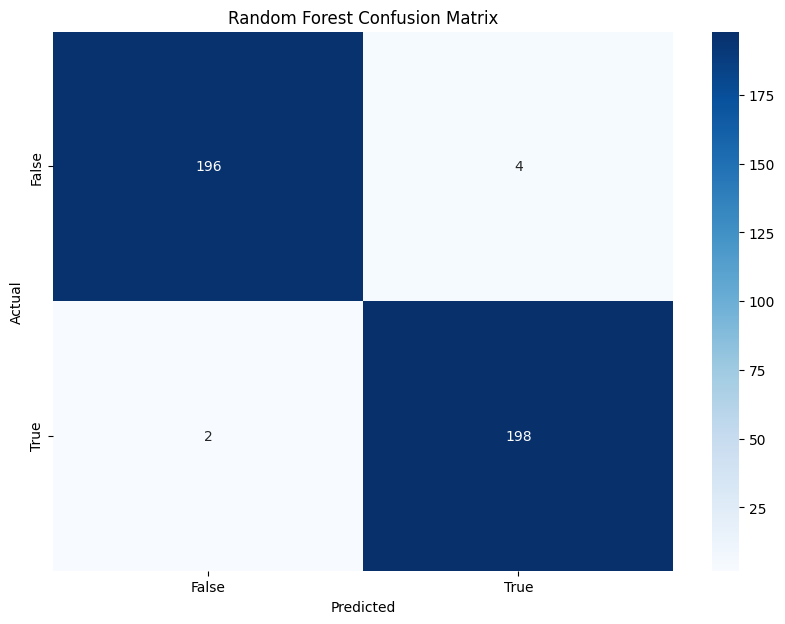

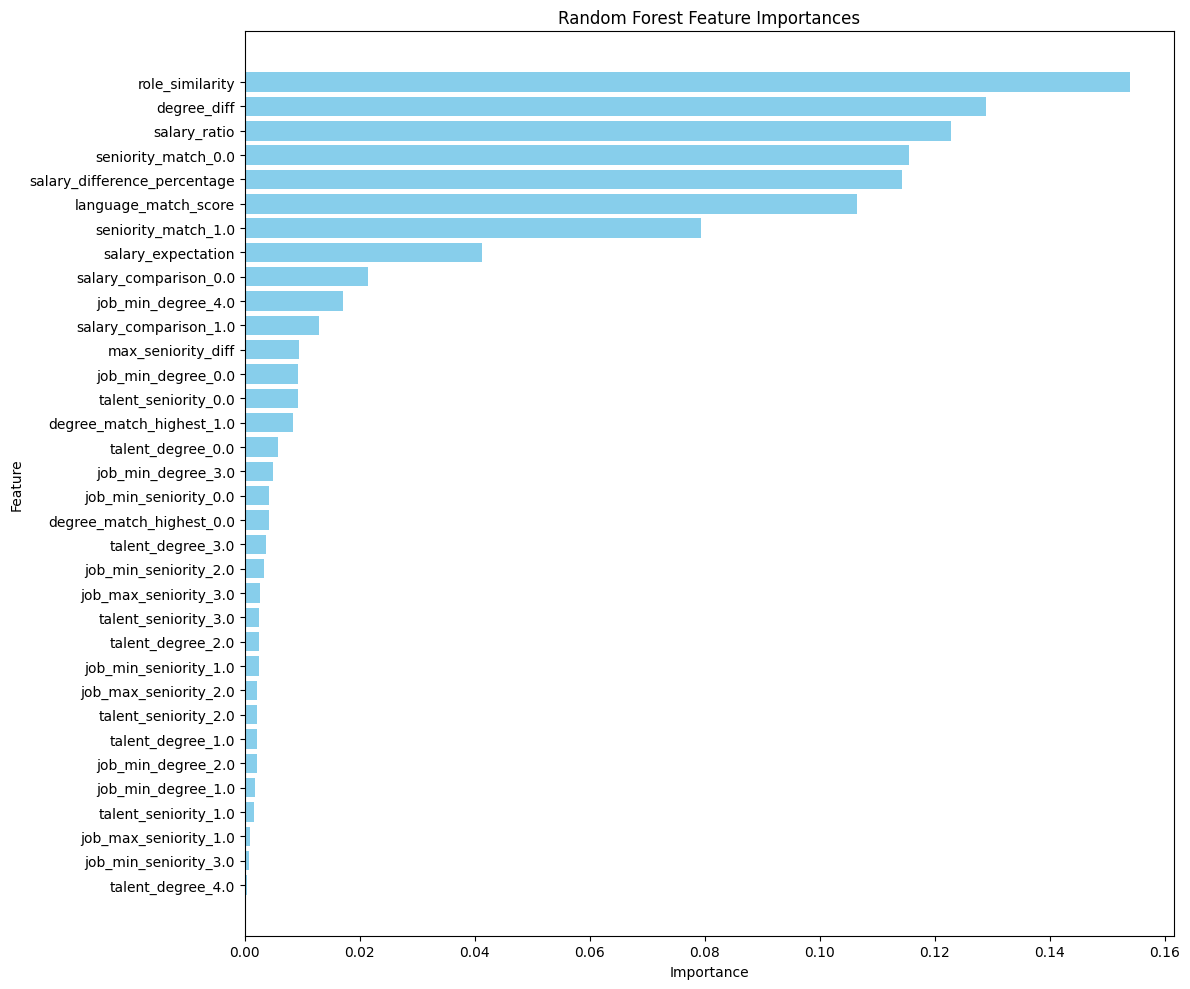

GradientBoostingClassifier Model
[[199   1]
 [  2 198]]
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       200
        True       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



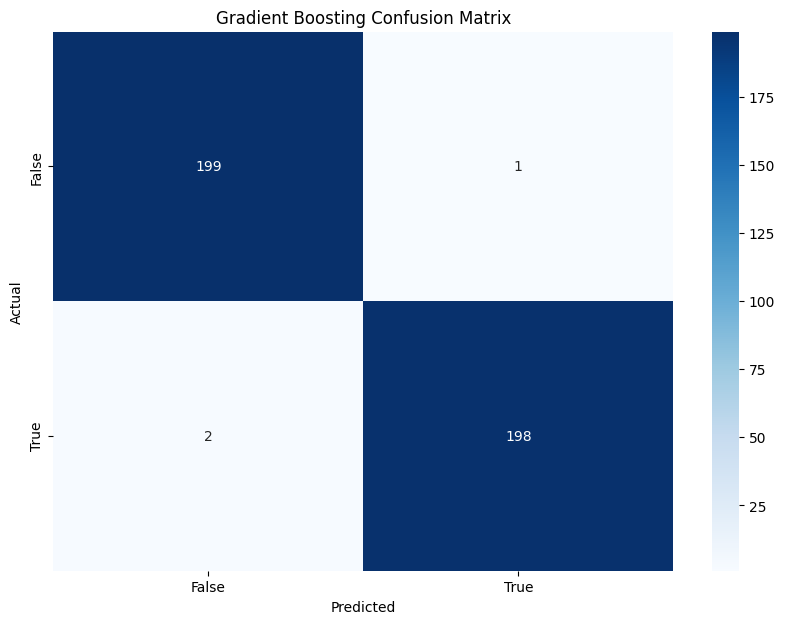

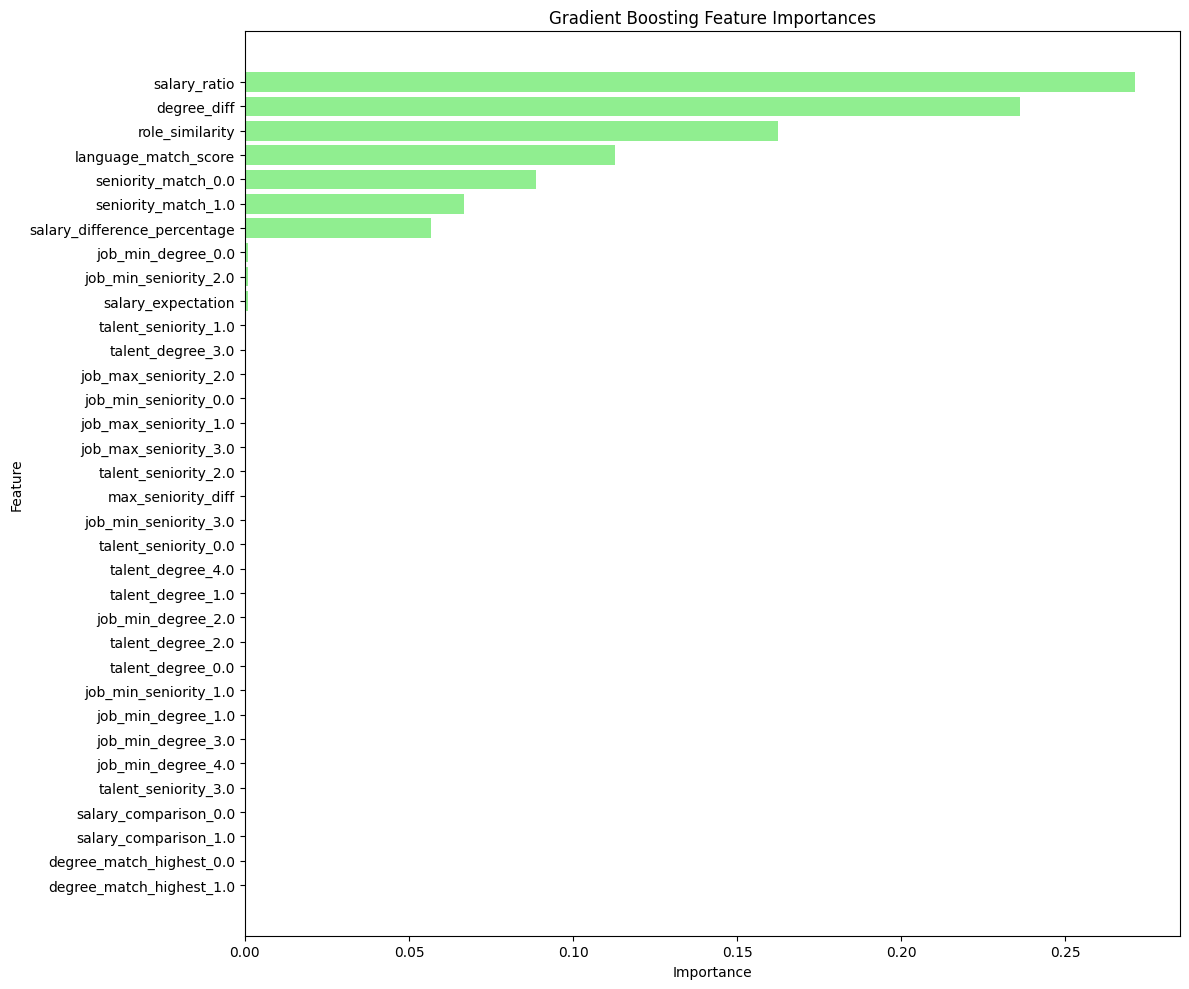

In [13]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

feature_names = feature_engineer.get_feature_names()

# Train the RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

print("Random Forest Model")
y_pred = rf_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, "Random Forest Confusion Matrix")

# Get feature importances
rf_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
rf_feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
})

# Sort the DataFrame by importance
rf_feature_importances_df = rf_feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances for RandomForest
plt.figure(figsize=(12, 10))
plt.barh(rf_feature_importances_df['Feature'], rf_feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Train the GradientBoosting model
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

print("GradientBoostingClassifier Model")
y_pred = gb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, "Gradient Boosting Confusion Matrix")

# Get feature importances
gb_importances = gb_model.feature_importances_

# Create a DataFrame for better visualization
gb_feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gb_importances
})

# Sort the DataFrame by importance
gb_feature_importances_df = gb_feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances for GradientBoosting
plt.figure(figsize=(12, 10))
plt.barh(gb_feature_importances_df['Feature'], gb_feature_importances_df['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Training RandomForest...
RandomForest Train Accuracy: 1.00
RandomForest Test Accuracy: 0.99
              precision    recall  f1-score   support

       False       0.99      0.98      0.99       200
        True       0.98      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



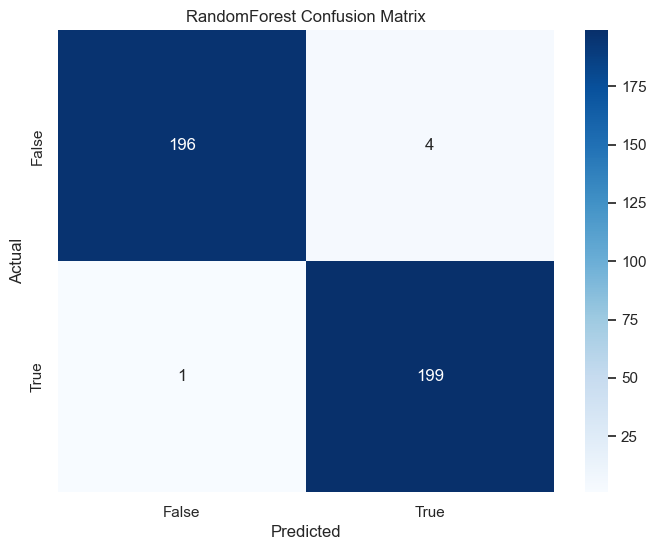

Training GradientBoosting...
GradientBoosting Train Accuracy: 1.00
GradientBoosting Test Accuracy: 0.99
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       200
        True       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



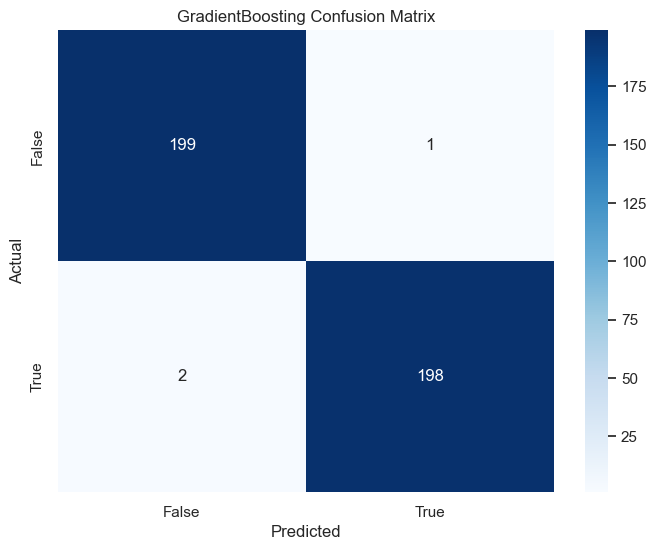

Training XGBoost...
XGBoost Train Accuracy: 1.00
XGBoost Test Accuracy: 0.98
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       200
        True       0.98      0.98      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



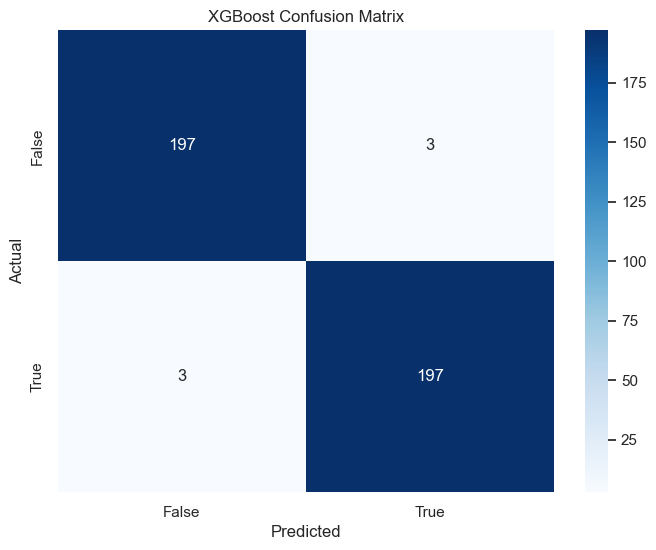

Training AdaBoost...
AdaBoost Train Accuracy: 0.99
AdaBoost Test Accuracy: 0.99
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       200
        True       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



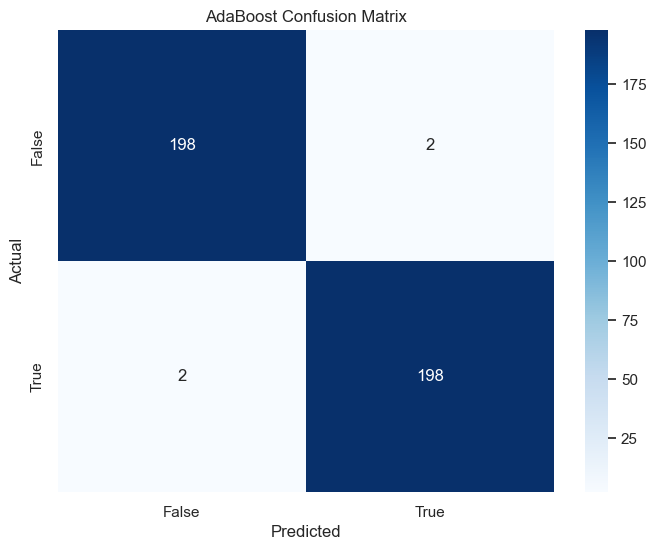

Training LogisticRegression...
LogisticRegression Train Accuracy: 0.95
LogisticRegression Test Accuracy: 0.95
              precision    recall  f1-score   support

       False       0.95      0.94      0.95       200
        True       0.94      0.95      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



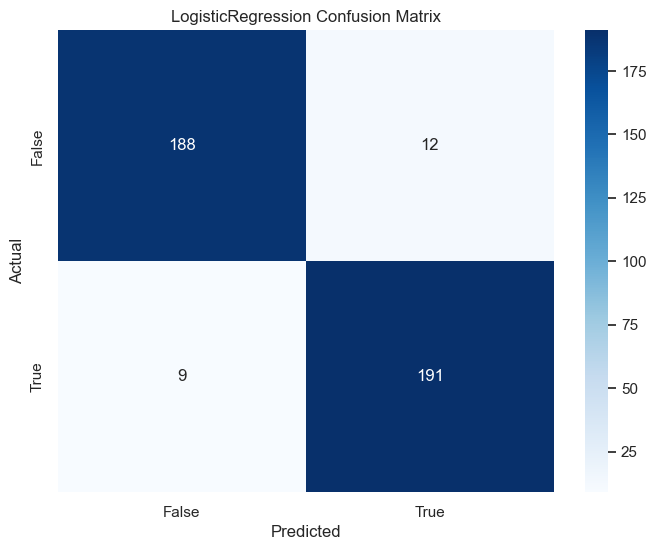

Training SVC...
SVC Train Accuracy: 0.98
SVC Test Accuracy: 0.98
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       200
        True       0.97      0.99      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



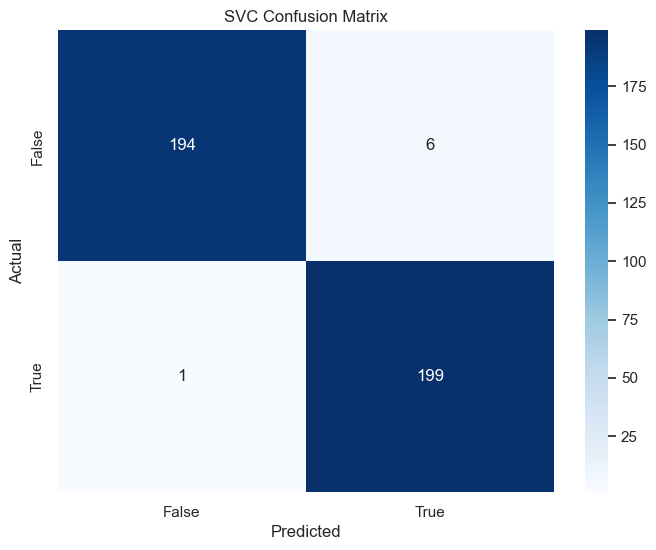

Training KNeighbors...
KNeighbors Train Accuracy: 0.95
KNeighbors Test Accuracy: 0.92
              precision    recall  f1-score   support

       False       0.99      0.84      0.91       200
        True       0.86      0.99      0.92       200

    accuracy                           0.92       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.93      0.92      0.92       400



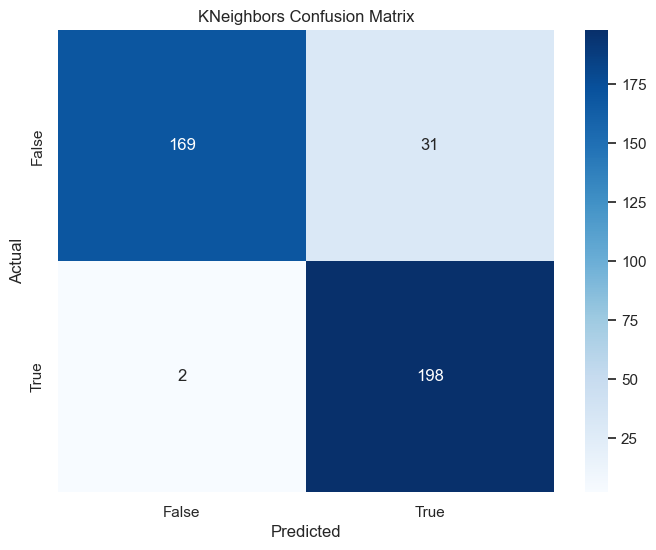

Training DecisionTree...
DecisionTree Train Accuracy: 1.00
DecisionTree Test Accuracy: 0.98
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       200
        True       0.98      0.97      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



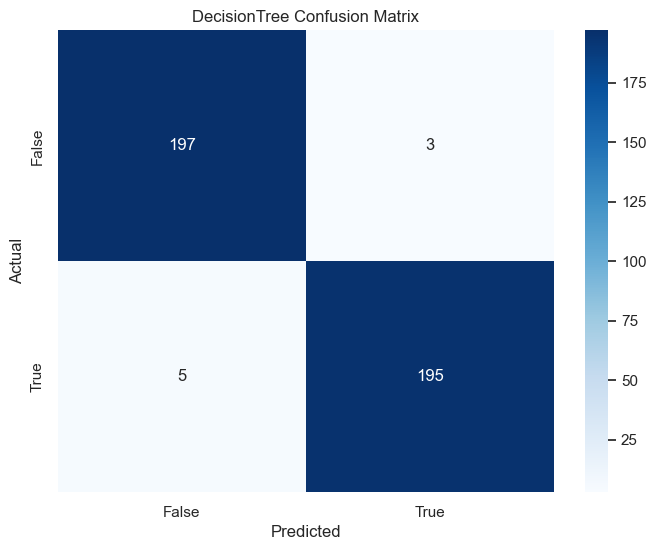

In [37]:
# List of models to try
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'KNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier()
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    
    # Evaluate the model
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    
    print(f"{model_name} Train Accuracy: {train_accuracy:.2f}")
    print(f"{model_name} Test Accuracy: {test_accuracy:.2f}")
    
    # Predict and generate classification report
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif


# List of models to try
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    # 'XGBoost': XGBClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'KNeighbors': KNeighborsClassifier(),
}
# Implement cross-validation
for model_name, model in models.items():
    cv_scores = cross_val_score(model, features, labels_df['label'], cv=5)
    print(f"{model_name} Cross-validation scores: {cv_scores}")
    print(f"{model_name} Mean CV score: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Feature selection
selector = SelectKBest(f_classif, k=10)  # Select top 10 features
X_new = selector.fit_transform(features, labels_df['label'])

# Get feature importance for tree-based models
if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier)):
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({'feature': range(features.shape[1]), 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    print(feature_importance.head(10))  # Print top 10 important features

# Add some noise to features
noisy_features = features + np.random.normal(0, 0.1, features.shape)

In [ ]:
# src/model.py


import joblib
import pandas as pd
from typing import Dict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

class TalentJobRanker:
    def __init__(self, model_path: str = None):
        # Load the model and feature engineer if a path is provided
        if model_path:
            self.model = joblib.load(model_path)
            self.feature_engineer = joblib.load(model_path.replace('model', 'feature_engineer'))
        else:
            # If no model path provided, set up for new training
            self.model = GradientBoostingClassifier()
            self.feature_engineer = FeatureEngineer()
    
    def fit(self, talent_df: pd.DataFrame, job_df: pd.DataFrame, labels: pd.DataFrame):
        # split job_df and talent_df into train and test and then fit feature engineer on train and transform on test
        job_df_train, job_df_test, talent_df_train, talent_df_test = train_test_split(job_df, talent_df, test_size=0.2, 
                                                                                    random_state=42, 
                                                                                    stratify=labels['label'])
        # Fit and transform the feature engineer
        X_train = self.feature_engineer.fit_transform(job_df_train, talent_df_train)
        X_test = self.feature_engineer.transform(job_df_test, talent_df_test)

        y_train = labels_df.loc[job_df_train.index, 'label']
        y_test = labels_df.loc[job_df_test.index, 'label']
        
        # Fit the model
        self.model = GradientBoostingClassifier() 
        self.model.fit(X_train, y_train)
        
        self.evaluate(X_test, y_test)

    def predict(self, talent: Dict, job: Dict) -> tuple:
        # Create dataframes from the input dictionaries
        talent_df = pd.DataFrame([talent])
        job_df = pd.DataFrame([job])
        # Transform features using the previously fitted feature engineer
        features = self.feature_engineer.transform(job_df, talent_df)
        # Predict the match label and score
        label = self.model.predict(features)[0]
        score = self.model.predict_proba(features)[0][1]  # Probability of positive class (match)
        return bool(label), float(score)
    
    def evaluate(self, features: np.ndarray, labels: np.ndarray):
        y_pred = self.model.predict(features)
        print(confusion_matrix(labels, y_pred))
        print(classification_report(y_test, y_pred))
        print("\n")


        # Get feature importances
        gb_importances = self.model.feature_importances_

        # Create a DataFrame for better visualization
        gb_feature_importances_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': gb_importances
        })

        # Sort the DataFrame by importance
        gb_feature_importances_df = gb_feature_importances_df.sort_values(by='Importance', ascending=False)

        return gb_feature_importances_df
    
    def save_model(self, model_path: str):
        # Save the model and feature engineer to specified path
        joblib.dump(self.model, model_path)
        joblib.dump(self.feature_engineer, model_path.replace('model', 'feature_engineer'))


# init and fit model
ranker = TalentJobRanker()
ranker.fit(talent_df, job_df, labels_df)

# predict
talent = {
    "languages": [{"title": "English", "rating": "C2"}, {"title": "German", "rating": "B2"}],
    "job_roles": ["software engineer", "data scientist"],
    "seniority": "midlevel",
    "salary_expectation": 80000,
    "degree": "master"
}

job = {
    "languages": [{"title": "English", "rating": "C1", "must_have": True}],
    "job_roles": ["software engineer"],
    "seniorities": ["midlevel", "senior"],
    "max_salary": 90000,
    "min_degree": "bachelor"
}

talent = pd.DataFrame([talent])
job = pd.DataFrame([job])

# clean data
talent, job = clean_data(talent, job)

label, score = ranker.predict(talent.to_dict('records')[0], job.to_dict('records')[0])
print("Match:", label, "Score:", score)


import joblib
from typing import Dict
import numpy as np
import pandas as pd

# from .feature_engineering import FeatureEngineer
import pandas as pd

def filter_talent(talent_df, job_df):
    """
    has_required_languages: Checks if the talent has all the required languages.
    has_matching_roles: Checks if any role in talent_df matches the roles in job_df.
    meets_degree_requirement: Checks if the talent's degree level meets or exceeds the job's minimum degree requirement.
    meets_seniority_requirement: Checks if the talent's seniority level meets or exceeds the job's minimum seniority requirement.
    filtered_indices: Collects the indices of rows in talent_df that meet all the conditions.
    Return Filtered DataFrame: Returns the filtered talent_df based on the collected indices.
    """
    def has_required_languages(index):
        # Assuming 'languages' is a list of required languages in job_df
        return all(lang in talent_df.loc[index, 'languages'] for lang in job_df.loc[index, 'required_languages'])

    def has_matching_roles(index):
        return any(role in talent_df.loc[index, 'job_roles'] for role in job_df.loc[index, 'job_roles'])

    def meets_degree_requirement(index):
        return talent_df.loc[index, 'degree_encoded'] >= job_df.loc[index, 'min_degree_encoded']

    def meets_seniority_requirement(index):
        return talent_df.loc[index, 'seniority_encoded'] >= job_df.loc[index, 'min_seniority_encoded']

    # Apply filters
    filtered_indices = [
        index for index in talent_df.index
        if has_required_languages(index)
        and has_matching_roles(index)
        and meets_degree_requirement(index)
        and meets_seniority_requirement(index)
    ]

    # Return the filtered DataFrame
    return talent_df.loc[filtered_indices]

class TalentJobMatcher:
    def __init__(self, model_path: str = None):
        if model_path:
            self.model = joblib.load(model_path)
            self.fe = joblib.load(model_path.replace('model', 'feature_engineer'))
        else:
            self.model = None
            self.fe = FeatureEngineer()
    
    def fit(self, df: pd.DataFrame):
        self.fe.fit(df)
        X = self.fe.transform(df)
        y = df['label']
        self.model.fit(X, y)
    
    def predict(self, talent: Dict, job: Dict) -> tuple:
        df = pd.DataFrame([{'talent': talent, 'job': job}])
        features = self.fe.transform(df)
        label = self.model.predict(features)[0]
        score = self.model.predict_proba(features)[0][1]  # Probability of positive class
        return bool(label), float(score)
    
    def save_model(self, model_path: str):
        joblib.dump(self.model, model_path)
        joblib.dump(self.fe, model_path.replace('model', 'feature_engineer'))
        

# train best models from sk learn


In [ ]:
import pandas as pd
from typing import List, Dict

class Retrieval:
    """
    The Retrieval class is responsible for filtering talent based on specified job requirements.

    Attributes:
        degree_hierarchy (dict): A mapping from degree strings to numerical values.
        seniority_hierarchy (dict): A mapping from seniority strings to numerical values.
    """
    def __init__(self, talent_df: pd.DataFrame, job_df: pd.DataFrame):
        """
        Initializes the Retrieval object with talent and job data.

        Args:
            talent_df (pd.DataFrame): DataFrame containing talent information.
            job_df (pd.DataFrame): DataFrame containing job information.
        """
        self.talent_df = talent_df
        self.job_df = job_df

    def has_required_languages(self, index: int) -> bool:
        """
        Checks if the talent has all the required languages for a job.

        Args:
            index (int): The index of the job in the job_df.

        Returns:
            bool: True if the talent meets the language requirements, False otherwise.
        """
        required_languages = self.job_df.loc[index, 'required_languages']
        talent_languages = [lang['title'] for lang in self.talent_df.loc[index, 'languages']]
        return all(lang in talent_languages for lang in required_languages)

    def has_matching_roles(self, index: int) -> bool:
        """
        Checks if the talent's job roles match any of the job roles in the job posting.

        Args:
            index (int): The index of the job in the job_df.

        Returns:
            bool: True if there is a match, False otherwise.
        """
        return any(role in self.talent_df.loc[index, 'job_roles'] for role in self.job_df.loc[index, 'job_roles'])

    def meets_degree_requirement(self, index: int) -> bool:
        """
        Checks if the talent's degree meets or exceeds the minimum degree requirement of the job.

        Args:
            index (int): The index of the job in the job_df.

        Returns:
            bool: True if the talent meets the degree requirement, False otherwise.
        """
        return self.talent_df.loc[index, 'degree_encoded'] >= self.job_df.loc[index, 'min_degree_encoded']

    def meets_seniority_requirement(self, index: int) -> bool:
        """
        Checks if the talent's seniority level meets or exceeds the minimum seniority requirement of the job.

        Args:
            index (int): The index of the job in the job_df.

        Returns:
            bool: True if the talent meets the seniority requirement, False otherwise.
        """
        talent_seniority = self.talent_df.loc[index, 'seniority_encoded']
        job_seniorities = self.job_df.loc[index, 'seniorities_encoded']
        return any(talent_seniority >= job_sen for job_sen in job_seniorities)

    def filter_talent(self) -> pd.DataFrame:
        """
        Filters the talents based on the job requirements.

        Returns:
            pd.DataFrame: A DataFrame of talents that meet all the job requirements.
        """
        filtered_indices = [
            index for index in self.talent_df.index
            if self.has_required_languages(index)
            and self.has_matching_roles(index)
            and self.meets_degree_requirement(index)
            and self.meets_seniority_requirement(index)
        ]

        return self.talent_df.loc[filtered_indices]

    def retrieve_matching_talents(self) -> pd.DataFrame:
        """
        Main method to retrieve talents that match job requirements.

        Returns:
            pd.DataFrame: A DataFrame of matching talents.
        """
        return self.filter_talent()


In [ ]:
# src/search/search.py

import asyncio
from typing import List, Dict
from models.retriver import TalentJobMatcher
from src.models.ranker import Ranker
from src.features.engineer import FeatureEngineer
from src.utils.logging import get_logger
from src.utils.metrics import timing_decorator
from src.search.cache import SearchCache

logger = get_logger(__name__)

class Search:
    def __init__(self, model_path: str = 'models/trained_model.pkl'):
        self.matcher = TalentJobMatcher(model_path)
        self.ranker = Ranker()
        self.feature_engineer = FeatureEngineer()
        self.cache = SearchCache()

    @timing_decorator
    def match(self, talent: Dict, job: Dict) -> Dict:
        cache_key = self.cache.generate_key(talent, job)
        cached_result = self.cache.get(cache_key)
        if cached_result:
            logger.info(f"Cache hit for {cache_key}")
            return cached_result

        features = self.feature_engineer.engineer_features(talent, job)
        label, score = self.matcher.predict(features)
        ranking_score = self.ranker.calculate_score(talent, job, score)

        result = {
            "talent": talent,
            "job": job,
            "label": bool(label),
            "score": float(score),
            "ranking_score": float(ranking_score)
        }

        self.cache.set(cache_key, result)
        return result

    @timing_decorator
    async def match_bulk(self, talents: List[Dict], jobs: List[Dict]) -> List[Dict]:
        async def match_combination(talent, job):
            return self.match(talent, job)

        tasks = [match_combination(talent, job) for talent in talents for job in jobs]
        results = await asyncio.gather(*tasks)

        # Sort results by ranking_score in descending order
        return sorted(results, key=lambda x: x['ranking_score'], reverse=True)

    def warm_up_cache(self, talents: List[Dict], jobs: List[Dict]):
        """Pre-compute and cache results for common queries"""
        for talent in talents[:100]:  # Limit to top 100 talents for example
            for job in jobs[:100]:  # Limit to top 100 jobs
                self.match(talent, job)

    def update_model(self, new_model_path: str):
        """Hot-swap the model without downtime"""
        new_matcher = TalentJobMatcher(new_model_path)
        self.matcher = new_matcher
        self.cache.clear()  # Clear cache when model is updated
        logger.info(f"Model updated to {new_model_path}")

In [12]:
features.shape, labels_df.shape

((2000, 21), (2000, 1))

In [42]:
# feature importance of model 

model.feature_importances_ # plot

# plot feature importance 




AttributeError: `feature_names_in_` is defined only when `X` has feature names that are all strings.

In [25]:
import pandas as pd

# Convert X_test and y_test to pandas DataFrame/Series
X_test_df = pd.DataFrame(X_test)
y_test_series = pd.Series(y_test.to_numpy().flatten(), name='Actual')

# Get misclassified examples
misclassified_indices = y_test_series.index[y_test_series != y_pred]
misclassified_examples = X_test_df.loc[misclassified_indices]
misclassified_examples['Actual'] = y_test_series.loc[misclassified_indices]
misclassified_examples['Predicted'] = y_pred[misclassified_indices]

# Display misclassified examples
print("Misclassified Examples:")
print(misclassified_examples)

Misclassified Examples:
            0         1   2         3   4         5    6    7    8    9  ...  \
1    0.639940  0.737360 NaN -0.993744 NaN -0.993078  1.0  0.0  1.0  0.0  ...   
8    0.639940  0.805047 NaN -0.683189 NaN -0.535668  1.0  0.0  0.0  1.0  ...   
26   0.639940 -0.398079 NaN  0.578202 NaN -0.444186  1.0  1.0  0.0  0.0  ...   
27   0.639940  0.151208 NaN  0.559032 NaN  0.379152  1.0  0.0  0.0  1.0  ...   
28   0.639940  0.310229 NaN  0.132018 NaN  0.470634  1.0  0.0  0.0  1.0  ...   
32   0.639940  1.252066 NaN -0.683189 NaN -0.535668  1.0  0.0  0.0  1.0  ...   
34   0.639940  0.368999 NaN -0.400407 NaN  0.013224  1.0  0.0  0.0  1.0  ...   
53   0.639940  0.395917 NaN -0.185007 NaN  0.150447  1.0  0.0  0.0  1.0  ...   
62   0.639940  1.369305 NaN  0.041440 NaN  0.836563  1.0  0.0  0.0  1.0  ...   
67  -0.626015 -0.588876 NaN -1.166275 NaN -0.535668  1.0  0.0  1.0  0.0  ...   
77   0.639940  0.537480 NaN  0.267886 NaN  0.607857  1.0  0.0  0.0  1.0  ...   
135  0.639940 -0

In [37]:
import pandas as pd

# Assuming y_test and y_pred are already defined
# Assuming original_df is the original DataFrame

# Convert y_test to a pandas Series if it's not already
y_test_series = pd.Series(y_test.to_numpy().flatten(), name='Actual')

# Get misclassified indices
misclassified_indices = y_test_series.index[y_test_series != y_pred]

# Fetch misclassified examples from the original DataFrame
misclassified_examples = df.loc[misclassified_indices]

# Add actual and predicted values to the misclassified examples
misclassified_examples['Actual'] = y_test_series.loc[misclassified_indices].values
misclassified_examples['Predicted'] = y_pred[misclassified_indices]

# Display misclassified examples
print("Misclassified Examples:")
misclassified_examples

Misclassified Examples:


,degree,job_roles,languages,salary_expectation,seniority,degree_encoded,seniority_encoded,job_roles,languages,max_salary,min_degree,seniorities,min_degree_encoded,min_seniority_encoded,label,Actual,Predicted
1,master,"[frontend-developer, full-stack-developer, c-c...","[{'rating': 'C2', 'title': 'German'}, {'rating...",44000,junior,3,1,[frontend-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,none,"[junior, midlevel]",0,1,True,False,1
8,bachelor,"[c-c-developer, qa-engineer, devops-engineer]","[{'rating': 'C2', 'title': 'German'}, {'rating...",70000,midlevel,2,2,[c-c-developer],"[{'title': 'English', 'rating': 'C1', 'must_ha...",65000,none,"[junior, midlevel, senior]",0,1,True,False,1
26,bachelor,"[software-architect, data-engineer, data-analyst]","[{'rating': 'C2', 'title': 'German'}, {'rating...",50000,junior,2,1,[data-analyst],"[{'title': 'German', 'rating': 'C1', 'must_hav...",67000,bachelor,"[junior, midlevel, senior]",2,1,True,True,0
27,master,"[product-manager, sales-manager, key-account-m...","[{'rating': 'C2', 'title': 'German'}, {'rating...",38000,midlevel,3,2,"[key-account-manager, customer-success-manager]","[{'title': 'German', 'rating': 'C2', 'must_hav...",70000,none,"[junior, midlevel, senior]",0,1,True,False,1
28,bachelor,"[c-net-developer, java-developer, c-c-develope...","[{'rating': 'C2', 'title': 'German'}, {'rating...",25000,none,2,0,"[full-stack-developer, java-developer]","[{'title': 'German', 'rating': 'C1', 'must_hav...",82000,bachelor,"[none, junior, midlevel, senior]",2,0,True,False,1
32,bachelor,"[frontend-developer, product-manager, product-...","[{'rating': 'C2', 'title': 'German'}, {'rating...",52000,junior,2,1,[frontend-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,none,"[junior, midlevel]",0,1,True,False,1
34,bachelor,[frontend-developer],"[{'rating': 'C1', 'title': 'German'}, {'rating...",65000,midlevel,2,2,[frontend-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,none,"[junior, midlevel]",0,1,True,False,1
53,master,"[full-stack-developer, mobile-developer, qa-en...","[{'rating': 'C2', 'title': 'German'}, {'rating...",63000,junior,3,1,"[c-c-developer, qa-engineer]","[{'title': 'German', 'rating': 'B2', 'must_hav...",70000,bachelor,"[junior, midlevel, senior]",2,1,True,False,1
62,apprenticeship,"[graphic-designer, online-marketing-manager, p...","[{'rating': 'C2', 'title': 'German'}, {'rating...",40000,junior,1,1,"[online-marketing-manager, content-marketing-m...","[{'title': 'German', 'rating': 'C2', 'must_hav...",50000,none,"[none, junior]",0,0,True,False,1
67,master,"[sales-team-lead, sales-manager, key-account-m...","[{'rating': 'C2', 'title': 'German'}, {'rating...",80000,senior,3,3,"[key-account-manager, customer-success-manager]","[{'title': 'German', 'rating': 'C2', 'must_hav...",70000,none,"[junior, midlevel, senior]",0,1,True,False,1


In [38]:
import pandas as pd

# Display misclassified examples
print("Misclassified Examples:")
misclassified_examples

# Define hierarchies
degree_hierarchy = {
    'none': 0,
    'apprenticeship': 1,
    'bachelor': 2,
    'master': 3,
    'doctorate': 4
}

seniority_hierarchy = {
    'none': 0,
    'junior': 1,
    'midlevel': 2,
    'senior': 3
}

# Encode the degrees
talent_df['degree_encoded'] = talent_df['degree'].map(degree_hierarchy)
job_df['min_degree_encoded'] = job_df['min_degree'].map(degree_hierarchy)

# Encode the seniorities
talent_df['seniority_encoded'] = talent_df['seniority'].map(seniority_hierarchy)
job_df['min_seniority_encoded'] = job_df['seniorities'].apply(lambda x: min([seniority_hierarchy[sen] for sen in x]))

# Join the dataframes on index
df = pd.concat([talent_df, job_df, labels_df], axis=1)
df.head(3)

# Function to check if all candidates have all must-have languages
def check_language_requirements(talent_df, job_df, misclassified_examples):
    def rating_to_level(rating):
        levels = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}
        return levels.get(rating, 0)
    
    def has_required_languages(candidate_languages, job_languages):
        candidate_dict = {lang['title']: rating_to_level(lang['rating']) for lang in candidate_languages}
        for job_lang in job_languages:
            if job_lang.get('must_have', False):
                job_title = job_lang['title']
                job_rating = rating_to_level(job_lang['rating'])
                if candidate_dict.get(job_title, 0) < job_rating:
                    return False
        return True
    
    for index in misclassified_examples.index:
        candidate_languages = talent_df.loc[index, 'languages']
        job_languages = job_df.loc[index, 'languages']
        if not has_required_languages(candidate_languages, job_languages):
            return False
    return True

# Example usage
result = check_language_requirements(talent_df, job_df, misclassified_examples)
print("All misclassified examples have all must_have criteria fulfilled:", result)

# Function to check requirements
non_compliant_rows = []

for index in misclassified_examples.index:
    candidate_max_salary = talent_df.loc[index, 'salary_expectation']
    job_max_salary = job_df.loc[index, 'max_salary']
    if candidate_max_salary > job_max_salary:
        reason = 'Salary expectation too high'
        non_compliant_rows.append({**talent_df.loc[index], **job_df.loc[index], **labels_df.loc[index], 'reason': reason})
    elif not any(role in talent_df.loc[index, 'job_roles'] for role in job_df.loc[index, 'job_roles']):
        reason = 'No matching job roles'
        non_compliant_rows.append({**talent_df.loc[index], **job_df.loc[index], **labels_df.loc[index], 'reason': reason})
    elif talent_df.loc[index, 'degree_encoded'] < job_df.loc[index, 'min_degree_encoded']:
        reason = 'Degree not sufficient'
        non_compliant_rows.append({**talent_df.loc[index], **job_df.loc[index], **labels_df.loc[index], 'reason': reason})
    elif talent_df.loc[index, 'seniority_encoded'] < job_df.loc[index, 'min_seniority_encoded']:
        reason = 'Seniority not sufficient'
        non_compliant_rows.append({**talent_df.loc[index], **job_df.loc[index], **labels_df.loc[index], 'reason': reason})

non_compliant_df = pd.DataFrame(non_compliant_rows)

# Only salary too high for job found that it cannot be a filter since it is not a must have
# but we can filter by max salary, must_have_language, degree and seniority


Misclassified Examples:
All misclassified examples have all must_have criteria fulfilled: True


In [39]:
non_compliant_df

,degree,job_roles,languages,salary_expectation,seniority,degree_encoded,seniority_encoded,max_salary,min_degree,seniorities,min_degree_encoded,min_seniority_encoded,label,reason
0,bachelor,[c-c-developer],"[{'title': 'English', 'rating': 'C1', 'must_ha...",70000,midlevel,2,2,65000,none,"[junior, midlevel, senior]",0,1,True,Salary expectation too high
1,master,"[key-account-manager, customer-success-manager]","[{'title': 'German', 'rating': 'C2', 'must_hav...",80000,senior,3,3,70000,none,"[junior, midlevel, senior]",0,1,True,Salary expectation too high
2,master,"[full-stack-developer, java-developer]","[{'title': 'German', 'rating': 'C1', 'must_hav...",90000,senior,3,3,82000,bachelor,"[none, junior, midlevel, senior]",2,0,True,Salary expectation too high
3,bachelor,[php-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,senior,2,3,65000,none,"[midlevel, senior]",0,2,True,Salary expectation too high
4,bachelor,"[frontend-developer, backend-developer, full-s...","[{'title': 'German', 'rating': 'C2', 'must_hav...",55000,junior,2,1,50000,apprenticeship,"[junior, midlevel]",1,1,True,Salary expectation too high
5,master,[php-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,senior,3,3,65000,none,"[midlevel, senior]",0,2,True,Salary expectation too high


In [ ]:
# src/model.py

import joblib
from typing import Dict
import numpy as np
import pandas as pd

# from .feature_engineering import FeatureEngineer

class TalentJobMatcher:
    def __init__(self, model_path: str = None):
        if model_path:
            self.model = joblib.load(model_path)
            self.fe = joblib.load(model_path.replace('model', 'feature_engineer'))
        else:
            self.model = None
            self.fe = FeatureEngineer()
    
    def fit(self, df: pd.DataFrame):
        self.fe.fit(df)
        X = self.fe.transform(df)
        y = df['label']
        self.model.fit(X, y)
    
    def predict(self, talent: Dict, job: Dict) -> tuple:
        df = pd.DataFrame([{'talent': talent, 'job': job}])
        features = self.fe.transform(df)
        label = self.model.predict(features)[0]
        score = self.model.predict_proba(features)[0][1]  # Probability of positive class
        return bool(label), float(score)
    
    def save_model(self, model_path: str):
        joblib.dump(self.model, model_path)
        joblib.dump(self.fe, model_path.replace('model', 'feature_engineer'))

In [66]:
non_compliant_df.reason.unique()

array(['Salary expectation too high'], dtype=object)

In [44]:
df.head(1)

,degree,job_roles,languages,salary_expectation,seniority,job_roles,languages,max_salary,min_degree,seniorities,label
0,bachelor,"[frontend-developer, backend-developer, full-s...","[{'rating': 'C2', 'title': 'German'}, {'rating...",48000,junior,[frontend-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,none,"[junior, midlevel]",True


In [ ]:
# Define hierarchies
degree_hierarchy = {
    'none': 0,
    'apprenticeship': 1,
    'bachelor': 2,
    'master': 3,
    'doctorate': 4
}

seniority_hierarchy = {
    'none': 0,
    'junior': 1,
    'midlevel': 2,
    'senior': 3
}

# Encode the degrees
talent_df['degree_encoded'] = talent_df['degree'].map(degree_hierarchy)
job_df['min_degree_encoded'] = job_df['min_degree'].map(degree_hierarchy)

# Encode the seniorities
talent_df['seniority_encoded'] = talent_df['seniority'].map(seniority_hierarchy)
job_df['min_seniority_encoded'] = job_df['seniorities'].apply(lambda x: min([seniority_hierarchy[sen] for sen in x]))


In [43]:
# join the dataframes on index 
df = pd.concat([talent_df, job_df, labels_df], axis=1)
df.head(3)

,degree,job_roles,languages,salary_expectation,seniority,job_roles,languages,max_salary,min_degree,seniorities,label
0,bachelor,"[frontend-developer, backend-developer, full-s...","[{'rating': 'C2', 'title': 'German'}, {'rating...",48000,junior,[frontend-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,none,"[junior, midlevel]",True
1,master,"[frontend-developer, full-stack-developer, c-c...","[{'rating': 'C2', 'title': 'German'}, {'rating...",44000,junior,[frontend-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,none,"[junior, midlevel]",True
2,none,"[frontend-developer, backend-developer, php-de...","[{'rating': 'C2', 'title': 'English'}, {'ratin...",40000,senior,[php-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",65000,none,"[midlevel, senior]",True


In [16]:
talent_df.head(2)

,degree,job_roles,languages,salary_expectation,seniority
0,bachelor,"[frontend-developer, backend-developer, full-s...","[{'rating': 'C2', 'title': 'German'}, {'rating...",48000,junior
1,master,"[frontend-developer, full-stack-developer, c-c...","[{'rating': 'C2', 'title': 'German'}, {'rating...",44000,junior


In [17]:

# Standardizing text data
def standardize_text_columns(df, columns):
    for col in columns:
        df[col] = df[col].str.lower().str.strip()

standardize_text_columns(talent_df, ['seniority', 'degree'])
standardize_text_columns(job_df, ['min_degree'])


############################# Encoding Categorical Data #############################
# Define the degree levels and encoding
degree_hierarchy = {
    'none': 0,
    'apprenticeship': 1,
    'bachelor': 2,
    'master': 3,
    'doctorate': 4
}

# Encode the degrees
talent_df['degree_encoded'] = talent_df['degree'].map(degree_hierarchy)
job_df['min_degree_encoded'] = job_df['min_degree'].map(degree_hierarchy)


# # Create binary columns for cumulative qualifications
# talents_df['has_bachelor_or_higher'] = talents_df['degree_encoded'] >= degree_hierarchy['bachelor']
# talents_df['has_master_or_higher'] = talents_df['degree_encoded'] >= degree_hierarchy['master']
# talents_df['has_doctorate'] = talents_df['degree_encoded'] == degree_hierarchy['doctorate']

# # Optional: Create similar binary columns for job requirements if needed
# jobs_df['requires_bachelor_or_higher'] = jobs_df['min_degree_encoded'] >= degree_hierarchy['bachelor']
# jobs_df['requires_master_or_higher'] = jobs_df['min_degree_encoded'] >= degree_hierarchy['master']
# jobs_df['requires_doctorate'] = jobs_df['min_degree_encoded'] == degree_hierarchy['doctorate']


Unique 'min_degree' values from job_df:
['none' 'bachelor' 'master' 'apprenticeship' 'doctorate']
Unique 'degree' values from talent_df:
['bachelor' 'master' 'none' 'apprenticeship' 'doctorate']


In [ ]:
df.languages.iloc[0].iloc[1]

[{'title': 'German', 'rating': 'C1', 'must_have': True},
 {'title': 'English', 'rating': 'B2', 'must_have': True}]

In [ ]:
job_df['seniorities'].apply(lambda x: 'none' or None in x)

In [24]:
none_examples

,job_roles,languages,max_salary,min_degree,seniorities,min_degree_encoded,has_none


In [23]:
# # Convert each row in the 'seniorities' column to a list
# job_df['seniorities'] = job_df['seniorities'].apply(lambda x: x.split(','))

# # Convert each row in the 'job_roles' column to a list
# job_df['job_roles'] = job_df['job_roles'].apply(lambda x: x.split(','))

# Create a new column 'has_none' to indicate whether 'none' was present in 'seniorities'
job_df['has_none'] = job_df['seniorities'].apply(lambda x: 'none' in x or None in x)

# Remove 'none' from the 'seniorities' lists
job_df['seniorities'] = job_df['seniorities'].apply(lambda x: [level for level in x if level != 'none' and level is not None])

# Explore examples where there is 'none'
none_examples = job_df[job_df['seniorities'].apply(lambda x: 'none' in x)]

print("Transformed 'seniorities' column:")
print(job_df['seniorities'].head())

print("\nNew 'has_none' column:")
print(job_df['has_none'].head())

print("\nExamples where 'none' was present:")
none_examples = job_df[job_df['has_none']]
job_df.sample(10)

Transformed 'seniorities' column:
0    [junior, midlevel]
1    [junior, midlevel]
2    [midlevel, senior]
3    [junior, midlevel]
4            [midlevel]
Name: seniorities, dtype: object

New 'has_none' column:
0    False
1    False
2    False
3    False
4    False
Name: has_none, dtype: bool

Examples where 'none' was present:


,job_roles,languages,max_salary,min_degree,seniorities,min_degree_encoded,has_none
1522,[data-engineer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",80000,master,"[midlevel, senior]",3,False
714,[frontend-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,none,[midlevel],0,False
1458,[sales-manager],"[{'title': 'German', 'rating': 'C2', 'must_hav...",80000,bachelor,[senior],2,False
1479,[sales-manager],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,bachelor,"[junior, midlevel]",2,False
1633,[frontend-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,none,"[junior, midlevel]",0,False
1116,[frontend-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,master,"[junior, midlevel]",3,False
241,[frontend-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",70000,none,"[junior, midlevel]",0,False
696,[full-stack-developer],"[{'title': 'German', 'rating': 'B2', 'must_hav...",90000,apprenticeship,"[midlevel, senior]",1,False
66,[consulting],"[{'title': 'German', 'rating': 'C2', 'must_hav...",75000,none,"[midlevel, senior]",0,False
1104,[mobile-developer],"[{'title': 'German', 'rating': 'C1', 'must_hav...",77000,doctorate,"[midlevel, senior]",4,False


In [51]:
# Explore examples where there is 'none' in 'job_roles'
none_examples_job_roles = job_df[job_df['job_roles'].apply(lambda x: 'none' in x)]
none_examples_job_roles

,job_roles,languages,max_salary,min_degree,seniorities


In [26]:
talent_df.languages.iloc[0]

[{'rating': 'C2', 'title': 'German'},
 {'rating': 'C2', 'title': 'English'},
 {'rating': 'B2', 'title': 'French'},
 {'rating': 'A2', 'title': 'Turkish'}]

In [1]:
job_df.laguages.iloc[0]

NameError: name 'job_df' is not defined

In [ ]:
labels_df

In [ ]:
print("Talents DataFrame:")
print(talents_df.info())
print("\nJobs DataFrame:")
print(jobs_df.info())
print("\nLabels DataFrame:")
print(labels_df.info())


print("\nTalents Summary Statistics:")
print(talents_df.describe())
print("\nJobs Summary Statistics:")
print(jobs_df.describe())
print("\nLabels Summary Statistics:")
print(labels_df.describe())

In [10]:
import pandas as pd
import json

# Assuming the JSON data is stored in a variable called 'json_data'
data = json_data

# Function to flatten language data
def flatten_languages(languages, prefix=''):
    flattened = {}
    for i, lang in enumerate(languages, 1):
        flattened[f'{prefix}language_{i}_title'] = lang['title']
        flattened[f'{prefix}language_{i}_rating'] = lang['rating']
        if 'must_have' in lang:
            flattened[f'{prefix}language_{i}_must_have'] = lang['must_have']
    return flattened

# Prepare talents data
talents = []
for item in data:
    talent = item['talent']
    talent['label'] = item['label']
    talent.update(flatten_languages(talent['languages']))
    talent['job_roles'] = ','.join(talent['job_roles'])
    talents.append(talent)

# Create talents DataFrame
talents_df = pd.DataFrame(talents)

# Prepare jobs data
jobs = []
for item in data:
    job = item['job']
    job['label'] = item['label']
    job.update(flatten_languages(job['languages'], 'required_'))
    job['job_roles'] = ','.join(job['job_roles'])
    job['seniorities'] = ','.join(job['seniorities'])
    jobs.append(job)

# Create jobs DataFrame
jobs_df = pd.DataFrame(jobs)

# Reorder columns for better readability
talent_columns = ['label', 'seniority', 'degree', 'salary_expectation', 'job_roles'] + \
                 [col for col in talents_df.columns if col.startswith('language_')]
talents_df = talents_df[talent_columns]

job_columns = ['label', 'job_roles', 'seniorities', 'max_salary', 'min_degree'] + \
              [col for col in jobs_df.columns if col.startswith('required_language_')]
jobs_df = jobs_df[job_columns]

In [14]:
jobs_df.describe()

,max_salary
count,2000.000000
mean,72658.000000
std,9237.678461
min,45000.000000
25%,70000.000000
50%,70000.000000
75%,80000.000000
max,100000.000000


In [11]:
talents_df

,label,seniority,degree,salary_expectation,job_roles,language_1_title,language_1_rating,language_2_title,language_2_rating,language_3_title,...,language_4_title,language_4_rating,language_5_title,language_5_rating,language_6_title,language_6_rating,language_7_title,language_7_rating,language_8_title,language_8_rating
0,True,junior,bachelor,48000,"frontend-developer,backend-developer,full-stac...",German,C2,English,C2,French,...,Turkish,A2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,junior,master,44000,"frontend-developer,full-stack-developer,c-c-de...",German,C2,English,C2,Spanish,...,French,A2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,senior,none,40000,"frontend-developer,backend-developer,php-devel...",English,C2,Romanian,C2,German,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,junior,apprenticeship,46000,"frontend-developer,backend-developer,full-stac...",German,C2,English,C1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,midlevel,master,75000,"devops-engineer,frontend-developer,backend-dev...",German,C2,English,C1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,False,midlevel,apprenticeship,101250,"cloud-engineer,frontend-developer,system-engin...",German,A2,English,B2,French,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,False,none,bachelor,62639,"product-manager,sales-manager,key-account-mana...",German,C1,English,C1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,False,junior,bachelor,99220,"c-c-developer,machine-learning-engineer,ui-ux-...",German,C2,English,C1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,False,junior,bachelor,73440,content-marketing-manager,German,C2,English,C1,Dutch,...,French,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
jobs_df

,label,job_roles,seniorities,max_salary,min_degree,required_language_1_title,required_language_1_rating,required_language_1_must_have,required_language_2_title,required_language_2_rating,required_language_2_must_have
0,True,frontend-developer,"junior,midlevel",70000,none,German,C1,True,English,B2,True
1,True,frontend-developer,"junior,midlevel",70000,none,German,C1,True,English,B2,True
2,True,php-developer,"midlevel,senior",65000,none,German,C1,False,English,C1,True
3,True,frontend-developer,"junior,midlevel",70000,none,German,C1,True,English,B2,True
4,True,"backend-developer,full-stack-developer",midlevel,80000,bachelor,German,C1,True,English,C1,False
...,...,...,...,...,...,...,...,...,...,...,...
1995,False,sales-manager,"junior,midlevel,senior",75000,master,German,C1,True,NaN,NaN,NaN
1996,False,"sales-manager,presales-manager","none,junior",54000,none,German,C2,True,NaN,NaN,NaN
1997,False,"full-stack-developer,java-developer","senior,none,midlevel",82000,bachelor,German,C1,True,NaN,NaN,NaN
1998,False,frontend-developer,junior,54000,none,German,C1,True,English,B2,False


In [7]:
# src/feature_engineering.py

from typing import Dict
import numpy as np

def compare_language_levels(talent_level: str, required_level: str) -> int:
    levels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
    return levels.index(talent_level) - levels.index(required_level)

def engineer_features(talent: Dict, job: Dict) -> np.ndarray:
    features = []
    
    # Language match
    talent_languages = {lang['title']: lang['rating'] for lang in talent['languages']}
    job_languages = {lang['title']: lang['rating'] for lang in job['languages']}
    
    language_match_score = 0
    for lang, required_level in job_languages.items():
        if lang in talent_languages:
            talent_level = talent_languages[lang]
            if compare_language_levels(talent_level, required_level) >= 0:
                language_match_score += 1
    
    features.append(language_match_score / len(job_languages))
    
    # Job role match
    job_role_match = len(set(talent['job_roles']) & set(job['job_roles'])) / len(job['job_roles'])
    features.append(job_role_match)
    
    # Seniority match
    seniority_match = 1 if talent['seniority'] in job['seniorities'] else 0
    features.append(seniority_match)
    
    # Salary match
    salary_match = 1 if talent['salary_expectation'] <= job['max_salary'] else 0
    features.append(salary_match)
    
    # Degree match
    degree_levels = {'none': 0, 'bachelor': 1, 'master': 2, 'phd': 3}
    degree_match = 1 if degree_levels[talent['degree']] >= degree_levels[job['min_degree']] else 0
    features.append(degree_match)
    
    return np.array(features)


import sys
import numpy as np
sys.path.append('..')

# from src.data_processing import load_data, clean_data
# from src.feature_engineering import engineer_features
# from src.model import TalentJobMatcher

import numpy as np

# Prepare features and labels
data = load_data('data.json')
cleaned_data = clean_data(data)

X = np.array([engineer_features(item['talent'], item['job']) for item in cleaned_data])
y = np.array([item['label'] for item in cleaned_data])

KeyError: 'apprenticeship'

In [ ]:
{'talent': {'languages': [{'rating': 'C2', 'title': 'German'},
    {'rating': 'C2', 'title': 'English'},
    {'rating': 'B2', 'title': 'French'},
    {'rating': 'A2', 'title': 'Turkish'}],
   'job_roles': ['frontend-developer',
    'backend-developer',
    'full-stack-developer',
    'java-developer',
    'mobile-developer'],
   'seniority': 'junior',
   'salary_expectation': 48000,
   'degree': 'bachelor'}   {'title': 'English', 'rating': 'B2', 'must_have': True}],
   'job_roles': ['frontend-developer'],
   'seniorities': ['junior', 'midlevel'],
   'max_salary': 70000,
   'min_degree': 'none'},
  'label': True}

In [3]:
json_data = load_data('data.json')
json_data

[{'talent': {'languages': [{'rating': 'C2', 'title': 'German'},
    {'rating': 'C2', 'title': 'English'},
    {'rating': 'B2', 'title': 'French'},
    {'rating': 'A2', 'title': 'Turkish'}],
   'job_roles': ['frontend-developer',
    'backend-developer',
    'full-stack-developer',
    'java-developer',
    'mobile-developer'],
   'seniority': 'junior',
   'salary_expectation': 48000,
   'degree': 'bachelor'},
  'job': {'languages': [{'title': 'German', 'rating': 'C1', 'must_have': True},
    {'title': 'English', 'rating': 'B2', 'must_have': True}],
   'job_roles': ['frontend-developer'],
   'seniorities': ['junior', 'midlevel'],
   'max_salary': 70000,
   'min_degree': 'none'},
  'label': True},
 {'talent': {'languages': [{'rating': 'C2', 'title': 'German'},
    {'rating': 'C2', 'title': 'English'},
    {'rating': 'A2', 'title': 'Spanish'},
    {'rating': 'A2', 'title': 'French'}],
   'job_roles': ['frontend-developer',
    'full-stack-developer',
    'c-c-developer',
    'mobile-devel

In [8]:
import boto3

# Create an S3 client
s3 = boto3.client('s3')

# List all buckets
response = s3.list_buckets()
print('Existing buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')

Existing buckets:
  infra-service-cd-serverlessdeploymentbucket-wcmklmxg2mm8
  regn-ls-s3
  regn-ml-team
  regn-mvp-demo-bucket-1
  vodafn-ls-s3


In [9]:
import sqlite3

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('test.db')

# Create a cursor object
cursor = conn.cursor()

# Create a table
cursor.execute('''CREATE TABLE IF NOT EXISTS users
                  (id INTEGER PRIMARY KEY, name TEXT, age INTEGER)''')

# Insert a row of data
cursor.execute("INSERT INTO users (name, age) VALUES ('Alice', 30)")

# Save (commit) the changes
conn.commit()

# Query the database
cursor.execute("SELECT * FROM users")
print(cursor.fetchall())

# Close the connection
conn.close()

[(1, 'Alice', 30), (2, 'Alice', 30)]


In [10]:
import boto3
import json
import sqlite3

# Define the S3 bucket and prefix
BUCKET_NAME = 'regnwcc-ml-team'
PREFIX = FEEDBACK_PREFIX = 'ttt-interactions'

def migrate_s3_to_sqlite():
    # Connect to SQLite database (or create it if it doesn't exist)
    conn = sqlite3.connect('test.db')
    cursor = conn.cursor()

    # Create the tables if they don't exist
    cursor.execute('''CREATE TABLE IF NOT EXISTS chat_history (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        username TEXT NOT NULL,
                        question TEXT NOT NULL,
                        response TEXT NOT NULL,
                        style TEXT,
                        number_of_references INTEGER,
                        score_threshold REAL,
                        sources TEXT,
                        timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                    )''')

    cursor.execute('''CREATE TABLE IF NOT EXISTS search_analytics (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        username TEXT NOT NULL,
                        query TEXT NOT NULL,
                        result_count INTEGER NOT NULL,
                        has_click BOOLEAN DEFAULT FALSE,
                        timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                    )''')

    cursor.execute('''CREATE TABLE IF NOT EXISTS top_search_queries (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        query TEXT NOT NULL,
                        count INTEGER NOT NULL,
                        last_updated TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                    )''')

    # Create indexes for improved query performance
    cursor.execute('CREATE INDEX IF NOT EXISTS idx_search_analytics_username ON search_analytics(username)')
    cursor.execute('CREATE INDEX IF NOT EXISTS idx_search_analytics_query ON search_analytics(query)')
    cursor.execute('CREATE INDEX IF NOT EXISTS idx_top_search_queries_count ON top_search_queries(count DESC)')

    # Initialize S3 client
    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')

    # Iterate over the objects in the S3 bucket
    for page in paginator.paginate(Bucket=BUCKET_NAME, Prefix=PREFIX):
        for obj in page.get('Contents', []):
            response = s3.get_object(Bucket=BUCKET_NAME, Key=obj['Key'])
            chat = json.loads(response['Body'].read().decode('utf-8'))

            # Insert data into the chat_history table
            cursor.execute('''INSERT INTO chat_history (username, question, response, style, number_of_references, score_threshold, sources, timestamp)
                              VALUES (?, ?, ?, ?, ?, ?, ?, ?)''', 
                           (chat['username'], chat['question'], chat['response'], chat.get('style'), chat.get('number_of_references'), chat.get('score_threshold'), json.dumps(chat.get('sources')), chat.get('timestamp')))

    # Save (commit) the changes
    conn.commit()

    # Close the connection
    conn.close()

# Run the migration
migrate_s3_to_sqlite()


# test the migration
conn = sqlite3.connect('test.db')
cursor = conn.cursor()

# Query the chat_history table
cursor.execute("SELECT * FROM chat_history")
print(cursor.fetchall())

# convert to df
import pandas as pd


[(1, 'admin', 'Why is there a significantly lower proportion of dedicated CCM resources on the buy-side compared to the sell-side, and what impact does this have on contract management outcomes?', '*Disclaimer: The following response is based on WorldCC data but is not legal advice.*\n\nThere are several factors that contribute to the lower proportion of dedicated Contract and Commercial Management (CCM) resources on the buy-side compared to the sell-side, and these differences have direct implications on contract management outcomes.\n\n### Factors for Lower Proportion of Dedicated CCM Resources on the Buy-side\n\n1. **Developmental Stage and Accountability**:\n   Buy-side organizations are generally less advanced in their development of CCM competency. This is reflected in the significantly lower likelihood of having clear ownership or accountability for CCM. For instance, 27% of buy-side organizations have no dedicated CCM resources compared to just 9% on the sell-side [1].\n\n2. **

In [6]:
# convert to df
import pandas as pd

df = pd.read_sql_query("SELECT * FROM chat_history", conn)
df

c:\Users\Freedom\Anaconda3\envs\srb_rec\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,id,username,question,response,style,number_of_references,score_threshold,sources,timestamp
0,1,admin,Why is there a significantly lower proportion ...,*Disclaimer: The following response is based o...,Style 1 - Tim Style Based on Formal Structure:...,7,0.6,"{""7"": 0.99999744, ""8"": 0.9998118, ""12"": 0.9996...",None
1,2,afurner@worldcc.com,I was wondering if you had any metrics based o...,*Disclaimer: The following response is based o...,Style 1 - Tim Style Based on Formal Structure:...,7,0.6,"{""328"": 0.9081302, ""278"": 0.86013436, ""276"": 0...",None
2,3,afurner@worldcc.com,What is the cost of a contract in 2024?,*Disclaimer: I cannot answer the question base...,Style 1 - Tim Style Based on Formal Structure:...,7,0.6,{},None
3,4,afurner@worldcc.com,What is the latest thinking on the ethics and ...,*Disclaimer: The response is based on the Worl...,Style 1 - Tim Style Based on Formal Structure:...,7,0.6,"{""11"": 0.88856554, ""26"": 0.82403755}",None
4,5,afurner@worldcc.com,What is the latest thinking on the ethics and ...,*Disclaimer: The following response is based o...,Style 1 - Tim Style Based on Formal Structure:...,7,0.6,"{""91"": 0.81626, ""26"": 0.7525585, ""99"": 0.71213...",None
...,...,...,...,...,...,...,...,...,...
75,76,jdavis@worldcc.com,Do the key barriers to adopting new technology...,*Disclaimer: I can't answer the question based...,Style 1 - Tim Style Based on Formal Structure:...,7,0.8,{},None
76,77,jdavis@worldcc.com,Can you give me some advice on data monetisati...,*Disclaimer: I can't answer the question based...,Style 1 - Tim Style Based on Formal Structure:...,7,0.6,{},None
77,78,jdavis@worldcc.com,Can you advise me on sun protection for July i...,*Disclaimer: I am unable to answer this questi...,Style 1 - Tim Style Based on Formal Structure:...,7,0.6,{},None
78,79,jdavis@worldcc.com,Can you advise me on sun protection for July i...,*Disclaimer: I can only provide answers about ...,Style 3 - General Best Practice Legal Research...,7,0.6,{},None


In [12]:
df.iloc[1]['question']

'I was wondering if you had any metrics based on volume of contract intake requests to the ratio of contract professionals (contract managers/contract specialist) do the work.  For example, my team of Contract Professionals handle over 60% of the contract intake request for the legal team.  Is there a way for me to benchmark on what other companies are doing in that space?  We separate attorney work, contract professional work, and operations work.'